In [1]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy import stats
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from random import randrange

import re

import random
import pickle,pprint

from scipy.stats import gamma
from scipy.optimize import minimize

%matplotlib inline

In [5]:
# this is just to have figure with large fontsize
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab20.colors)

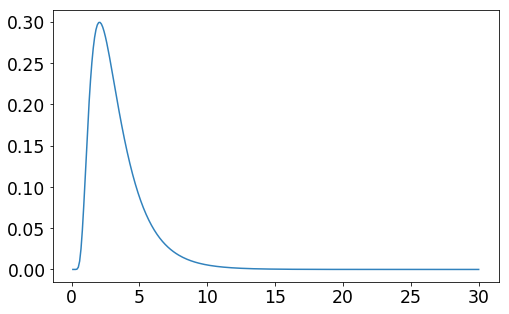

In [21]:
#Cv=0.3
#R=0.05

#V_th=1
#mu=R*V_th
#D=0.5*mu*V_th*Cv**2

D=0.05
V_th=1
mu=0.3


t_window=30
dt=0.1
N=int(t_window/dt)

N_sim=int(150/dt)

t_vec=[dt*(i+1) for i in range(N)]

def Prcv(t,mu,V_th,D):
    
    R=mu/V_th
    Cv=np.sqrt(2*D/(mu*V_th))
    
    if t==0:
        return 0
    else:
        return (Cv**(-1)/(np.sqrt(2*np.pi*R*t**3)))*np.exp(-Cv**(-2)*(R*t-1)**2/(2*R*t))
    
def P(t,mu,V_th,D):
    
    
    if t==0:
        return 0
    else:
        return (V_th/(np.sqrt(4*np.pi*D*t**3)))*np.exp(-(mu*t-V_th)**2/(4*D*t))

 
P_=[P(t,mu,V_th,D) for t in t_vec]


def PLrcv(l):
    return np.exp(Cv**(-2)*(1-np.sqrt(1+(2*l*Cv**2)/R)))

def PL(l,mu,V_th,D):
    return np.exp((mu*V_th/(2*D))*(1-np.sqrt(1+(4*l*D)/(mu**2))))

plt.plot(t_vec,P_)


In [22]:
print(mu,D,V_th)

0.3 0.05 1


In [23]:
def PHI(x):
    return 0.5*(1+sc.special.erf(x/np.sqrt(2)))


def Srcv(t,mu,V_th,D):
    
    R=mu/V_th
    Cv=np.sqrt(2*D/(mu*V_th))
    
    if t==0:
        return 1
    else:
        return 1-PHI(np.sqrt(Cv**(-2)/(t*R))*(t*R-1))-np.exp(2*Cv**(-2))*PHI(-np.sqrt(Cv**(-2)/(t*R))*(t*R+1))
    
def S(t,mu,V_th,D):
      
    if t==0:
        return 1
    else:
        return 1-PHI(np.sqrt(V_th**(2)/(t*2*D))*(t*mu/V_th-1))-np.exp(mu*V_th/D)*PHI(-np.sqrt(V_th**(2)/(t*2*D))*(t*mu/V_th+1))
    


In [24]:
def int_p():
    pint=np.zeros(len(P_))
    for n in range(len(P_)-1):
        pint[n+1]=pint[n]+0.5*dt*(P_[n+1]+P_[n])
    return pint

    

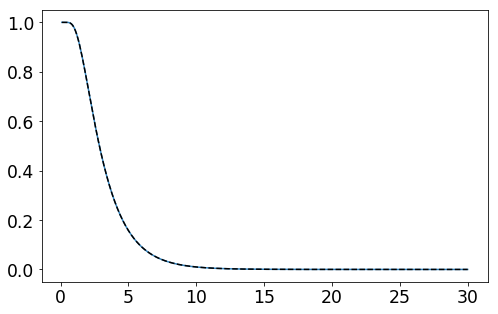

In [25]:
S_=[S(t,mu,V_th,D) for t in t_vec]
S_rcv=[Srcv(t,mu,V_th,D) for t in t_vec]
S_1=-int_p()+1
plt.plot(t_vec,S_)
plt.plot(t_vec,S_1,'--',c='k')

In [26]:
def RHO(t,mu,V_th,D):
    if t==0:
        return 0
    else:  
        return P(t,mu,V_th,D)/S(t,mu,V_th,D)#-(np.log(S(t+dt))-np.log(S(t-dt)))/(2*dt)
    
#def RHO(t):
#    return P(t)/S(t)

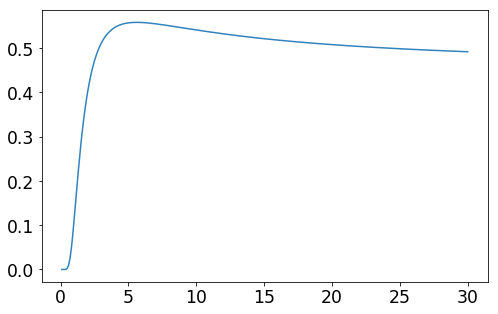

In [27]:
rho=np.copy([RHO(t,mu,V_th,D) for t in t_vec])
#rho1=np.copy([RHO1(t) for t in t_vec])
plt.plot(t_vec,rho)
#plt.plot(t_vec,rho1)
#plt.xlim(0,6)
#plt.ylim(0,1)

Numerical solution from density equation

In [28]:
q_old=np.zeros((N+1,1))
q_old[0]=1

q=np.zeros((N+1,int(N_sim/10)))

A=np.zeros((N_sim,1))

q_new=np.zeros((N+1,1))

i_store=0

for it in range(N_sim):
    
    t=it*dt
   
    A[it]=q_new[0]#/dt
    q_new = np.zeros((N + 1, 1))
   

    for ir in range(N):
        
        
        rho_ =  RHO(ir*dt,mu,V_th,D)


        q_new[ir + 1] = q_old[ir] * (1 - dt * rho_)
        q_new[0] += dt * rho_ * q_old[ir]

    
    rho = RHO(N*dt,mu,V_th,D)
    q_new[N] += q_old[N] * (1 - dt * rho)
    q_new[0] += dt * rho_ * q_old[N]
    
    q_new/=(np.sum(q_new*dt))


    q_old = q_new

    
    
    if it%10==0:
        q[:,i_store]=q_new.flatten()
        i_store+=1
        

(0, 30)

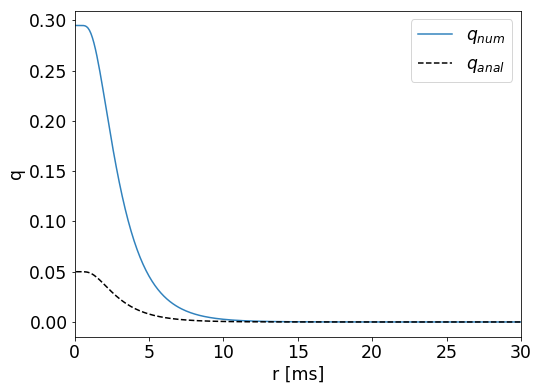

In [29]:

t_q=[j*dt for j in range(N+1)]
plt.figure(figsize=(8,6))
plt.plot(t_q, q[:,-1],label='$q_{num}$')
plt.plot(t_vec,R*np.copy(S_),label='$q_{anal}$',c='k',ls='--')
plt.xlabel('r [ms]')
plt.ylabel('q')
plt.legend()
plt.xlim(0,t_window)


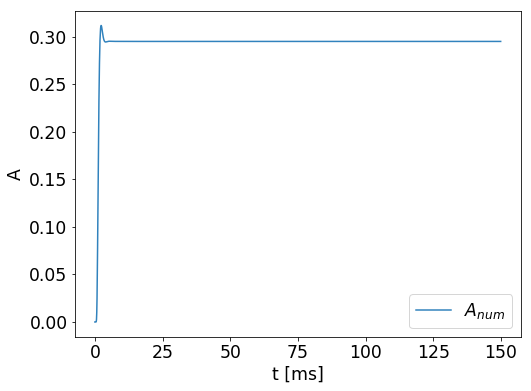

In [30]:
t_A=[(j)*dt for j in range(N_sim)]
plt.figure(figsize=(8,6))
plt.plot(t_A,A,label='$A_{num}$')
plt.xlabel('t [ms]')
plt.ylabel('A')
plt.legend()

L matrix

In [31]:
L=np.zeros((N+1,N+1))
for i in range(N-1):
    L[0,i+1]=RHO(i*dt,mu,V_th,D)*dt
    L[i+1,i+1]=-1-RHO(i*dt,mu,V_th,D)*dt
    L[i+2,i+1]=1
    
L[0,0]=-1
L[1,0]=1
L[0,N]=1
L[N,N]=-1

In [32]:
def th_spectrumrcv(n_max,mu,V_th,D):
    spectrum=[0]
    
    R=mu/V_th
    Cv=np.sqrt(2*D/(mu*V_th))
    
    for n in range(1,n_max+1):
        l1= 2*np.pi*R*1j*(n)  -  2*(np.pi**2)*(Cv**2)*R*(n**2)
        l2=-2*np.pi*R*1j*(n)  -  2*(np.pi**2)*(Cv**2)*R*(n**2)
        spectrum.append(l1)
        spectrum.append(l2)
    return spectrum


def th_spectrum(n_max,mu,V_th,D):
    spectrum=[0]
        
    for n in range(1,n_max+1):
        l1= 2*np.pi*mu*1j*(n)/V_th  -  4*(np.pi**2)*D*(n**2)/V_th**2
        l2=-2*np.pi*mu*1j*(n)/V_th  -  4*(np.pi**2)*D*(n**2)/V_th**2
        spectrum.append(l1)
        spectrum.append(l2)
    return spectrum


In [33]:
th_spectrum(1,mu,V_th,D)

[0,
 (-1.9739208802178716+1.8849555921538759j),
 (-1.9739208802178716-1.8849555921538759j)]

In [15]:
eigv, vec = np.linalg.eig(L)
eigv=eigv/dt
arr_idx = np.argsort(eigv.real)

for i in range(int((len(arr_idx))/2)): 
    
    if eigv[arr_idx[::-1][2*i+1]].imag<0 :
        
        first=1*arr_idx[::-1][2*i+1]
        second=1*arr_idx[::-1][2*i+2]
        
        arr_idx[::-1][2*i+1]=second
        arr_idx[::-1][2*i+2]=first
        
            
eigv = eigv[arr_idx[::-1]]
vec = vec[:,arr_idx[::-1]]


In [16]:
Lt=np.matrix.getH(L)
eigvt, vect = np.linalg.eig(Lt)
eigvt=eigvt/dt
arr_idxt = np.argsort(eigvt.real)

for i in range(int((len(arr_idxt))/2)): 
    
    if eigvt[arr_idxt[::-1][2*i+1]].imag<0 :
        
        first=1*arr_idxt[::-1][2*i+1]
        second=1*arr_idxt[::-1][2*i+2]
        
        arr_idxt[::-1][2*i+1]=second
        arr_idxt[::-1][2*i+2]=first
        
            
eigvt = eigvt[arr_idxt[::-1]]
vect = vect[:,arr_idxt[::-1]]


In [17]:
th_max=10
th_spect=th_spectrum(th_max,mu,V_th,D)

In [18]:
Al=np.zeros((N+1,N+1))
for i in range(N-1):
    Al[0,i+1]=RHO(i*dt,mu,V_th,D)*dt
    Al[i,i+1]=-1/2
    Al[i+1,i+1]=-RHO(i*dt,mu,V_th,D)*dt
    Al[i+2,i+1]=1/2
    
Al[0,0]=-1/2
Al[1,0]=1/2

Al[0,1]=-1/2+RHO(1*dt,mu,V_th,D)*dt
Al[1,1]=-RHO(1*dt,mu,V_th,D)*dt
Al[2,1]=1/2


Al[0,N]=1+1/2
Al[N-1,N]=-1/2
Al[N,N]=-1


lam, lam_vec = np.linalg.eig(Al)
lam=lam/dt

(-2.5, 2.5)

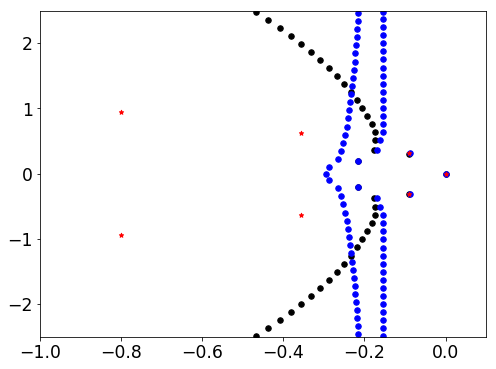

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(eigv.real, eigv.imag, s=30, marker='o', c='k')
plt.scatter(lam.real, lam.imag, s=30, marker='o', c='b')
for l in th_spect:
    plt.scatter(l.real, l.imag, s=20, marker='*', c='r')
    
plt.xlim(-1,0.1)
plt.ylim(-2.5,2.5)

In [20]:
for l in th_spect:
    print(PL(l,mu,V_th,D))

1.0
(1+2.44929359829e-16j)
(1-2.44929359829e-16j)
(1+4.89858719659e-16j)
(1-4.89858719659e-16j)
(1+4.28750175829e-15j)
(1-4.28750175829e-15j)
(1+9.79717439318e-16j)
(1-9.79717439318e-16j)
(1+1.22464679915e-15j)
(1-1.22464679915e-15j)
(1+8.57500351658e-15j)
(1-8.57500351658e-15j)
(1+1.71450551881e-15j)
(1-1.71450551881e-15j)
(1+1.95943487864e-15j)
(1-1.95943487864e-15j)
(1+9.30979159607e-15j)
(1-9.30979159607e-15j)
(1+2.44929359829e-15j)
(1-2.44929359829e-15j)


In [21]:
for i in range(10):
    print(PL(eigv[i],mu,V_th,D))

(1+0j)
(1.06065817677+0.093722006618j)
(1.06065817677-0.093722006618j)
(-0.481998557059+0.111872344427j)
(-0.481998557059-0.111872344427j)
(-0.00345353311841+0.165929351805j)
(-0.00345353311841-0.165929351805j)
(-0.139453695826-2.05978925054j)
(-0.139453695826+2.05978925054j)
(0.0611538868878+0.0240120361137j)


0.05 (0.0496673432713+0j)
0.05 (0.0470970377793+0.0289947800569j)
0.05 (0.0470970377793-0.0289947800569j)
0.05 (0.0149210197093+0.000429618457295j)
0.05 (0.0149210197093-0.000429618457295j)
0.05 (0.0195386108813+0.00202601551655j)
0.05 (0.0195386108813-0.00202601551655j)
0.05 (0.00606642540641-0.00990874154427j)
0.05 (0.00606642540641+0.00990874154427j)
0.05 (0.0208064649319+0.000382938301094j)


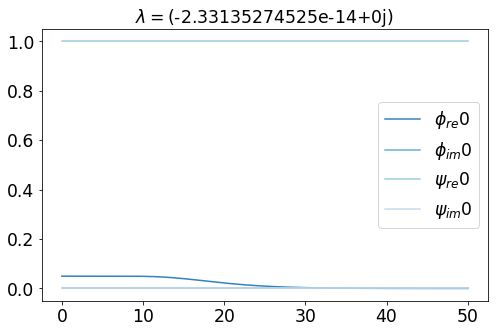

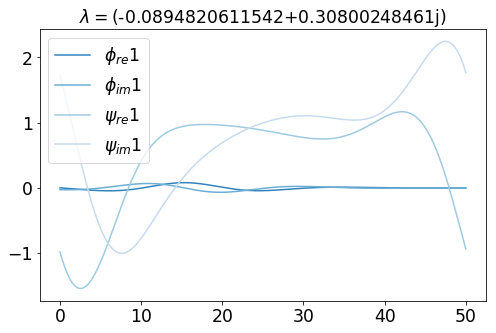

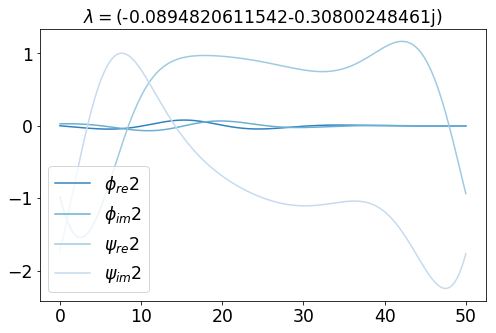

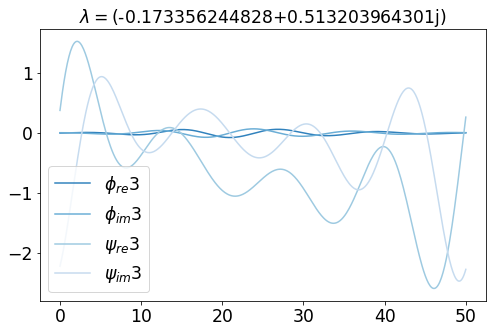

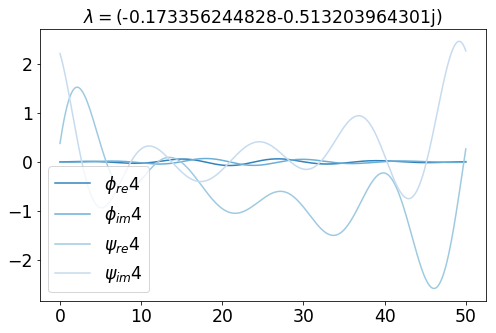

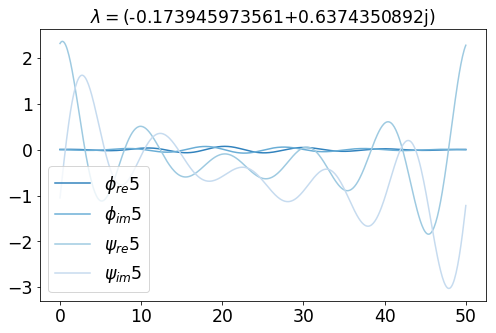

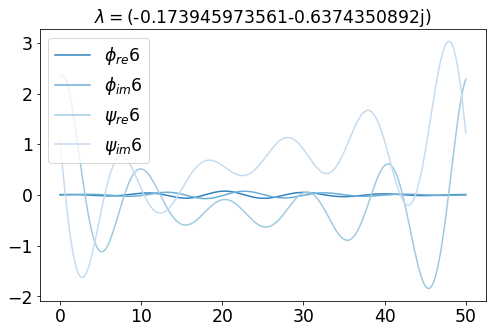

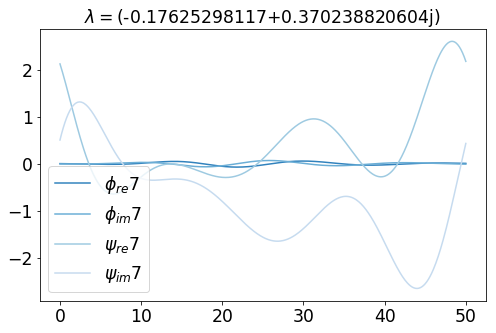

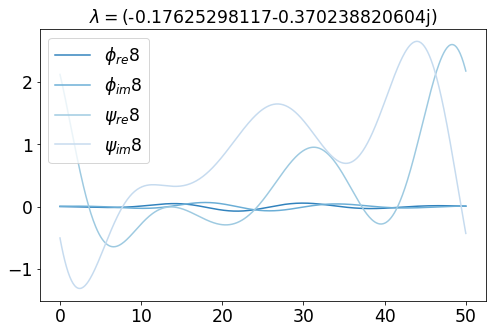

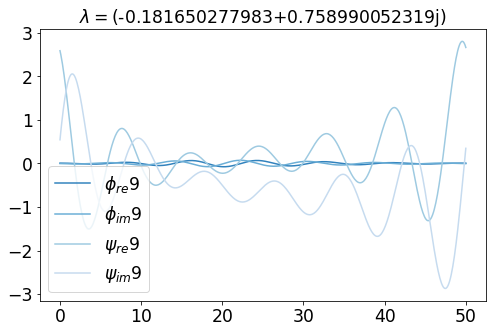

In [22]:
n_first=10

lambda_list=[]
qn0=[]
an0=[]

q_initial=np.zeros((N+1,1))
q_initial[0]=1

t_=[j*dt for j in range(N+1)]


for idx in range(n_first):
    
    lambda_list.append(eigv[idx])
    phi=1*vec[:,idx]
    psi=1*vect[:,idx]
    
        
    
    
    if idx==0:
        norm=abs(np.sum(vec[:,idx].real)*dt)
        phi=phi/norm
            
    if phi[0].real<0:
        phi=phi*(-1)
        
        
    normt=phi.dot(psi)*dt
    psi=psi/normt
        
    print(R,phi[0]*psi[0])
    
    plt.figure()
    plt.title('$\lambda=$'+str(eigv[idx]))
    plt.plot(t_,phi.real,label='$\phi_{re}$'+str(idx))
    plt.plot(t_,phi.imag,label='$\phi_{im}$'+str(idx))
    plt.plot(t_,psi.real,label='$\psi_{re}$'+str(idx))
    plt.plot(t_,psi.imag,label='$\psi_{im}$'+str(idx))
    plt.legend() 
        
    qn0.append(phi[0])
    an0.append(psi.dot(q_initial))
    
         
nu=np.zeros((N_sim,len(qn0)+1))
for i in range(N_sim):
    t=i*dt
    for n in range(len(qn0)):
        nu[i,n+1]= nu[i,n]+(np.exp(t*lambda_list[n])*qn0[n]*an0[n]).real
        


In [23]:
print(qn0[1]*lambda_list[1]*an0[1])
print(qn0[2]*lambda_list[2]*an0[2])

[-0.0131448+0.01191149j]
[-0.0131448-0.01191149j]


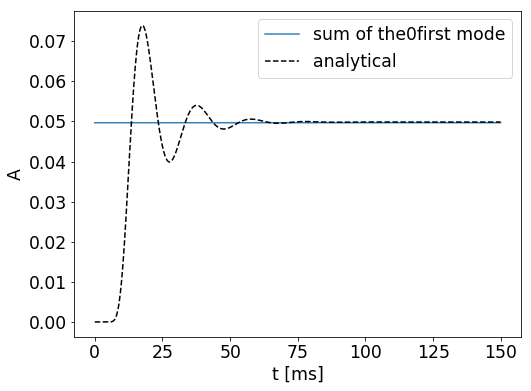

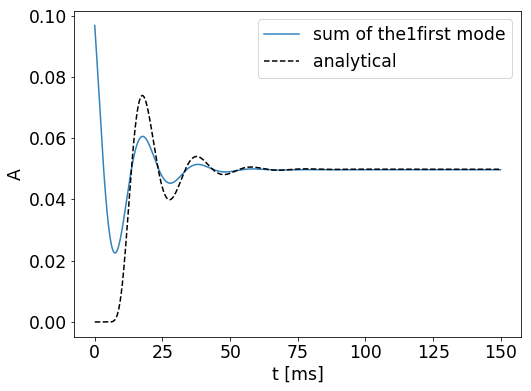

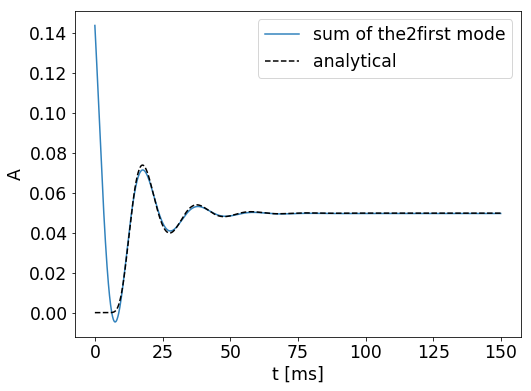

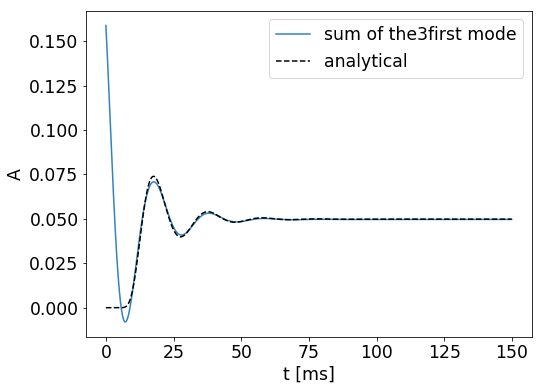

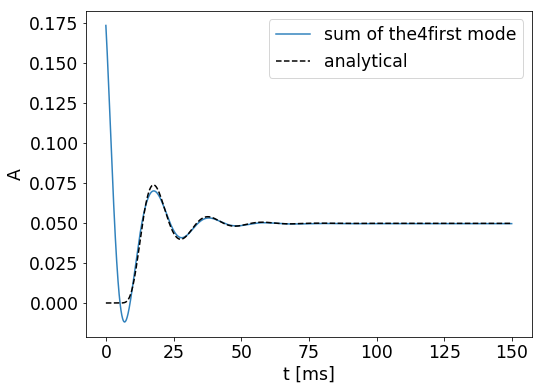

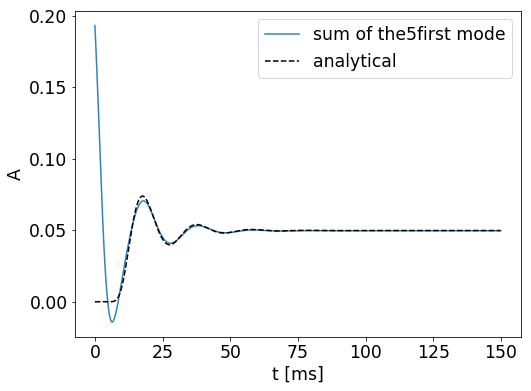

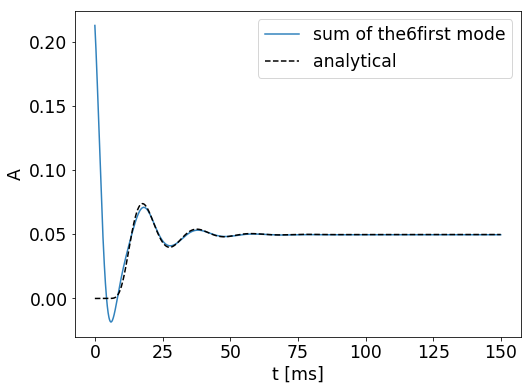

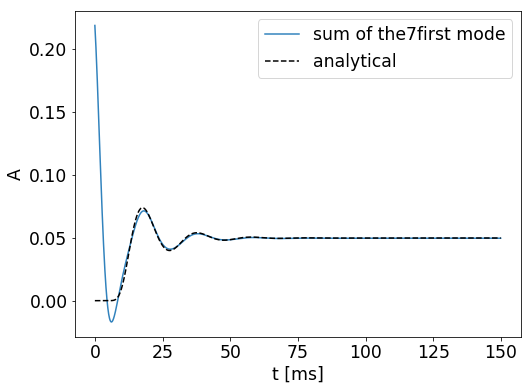

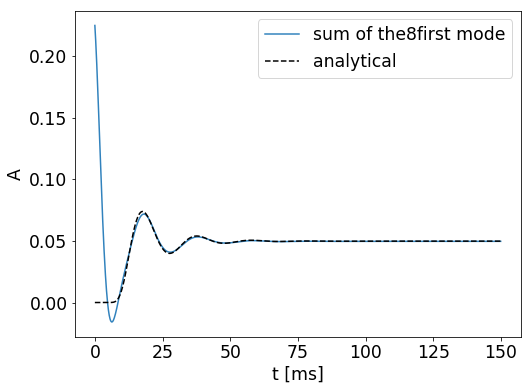

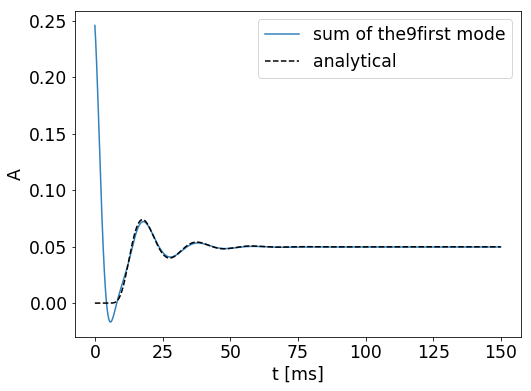

In [24]:
time=[i*dt for i in range(N_sim)]
plt.figure(figsize=(8,6))

for i in range(len(qn0)):
    plt.figure(figsize=(8,6))
    plt.plot(time,nu[:,i+1], label='sum of the' +str(i)+'first mode')
    plt.plot(t_A,A,c='k',ls='--',label='analytical')
    plt.xlabel('t [ms]')
    plt.ylabel('A')
    plt.legend()
 

In [25]:
def Pn(t,n,mu,V_th,D):
    
    R=mu/V_th
    Cv=np.sqrt(2*D/(mu*V_th))
    if t==0:
        return 0
    else:
        return n*(Cv**(-1)/(np.sqrt(2*np.pi*R*t**3)))*np.exp(-Cv**(-2)*(R*t-n)**2/(2*R*t))
    
    
def A_p(nmax,t_vec):
    a=np.zeros((len(t_vec),1))
    for it,t in enumerate(t_vec):
        for n in range(1,nmax+1):
            a[it]+=Pn(t,n,mu,V_th,D)
            
    return a   

In [26]:
t_A=[(j)*dt for j in range(N_sim)]
a_p=A_p(20,t_A)

(0, 0.15)

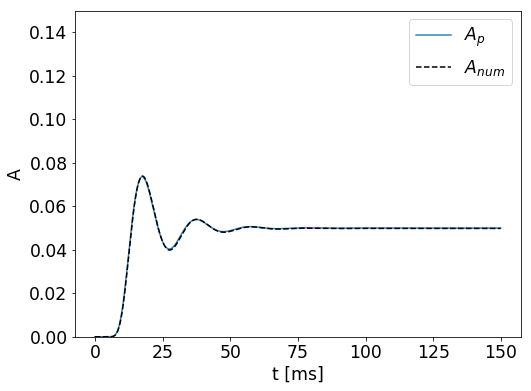

In [27]:
plt.figure(figsize=(8,6))
plt.plot(t_A,a_p,label='$A_p$')
plt.plot(t_A,A,label='$A_{num}$',ls='--',c='k')
plt.xlabel('t [ms]')
plt.ylabel('A')
plt.legend()
plt.ylim(0,0.15)

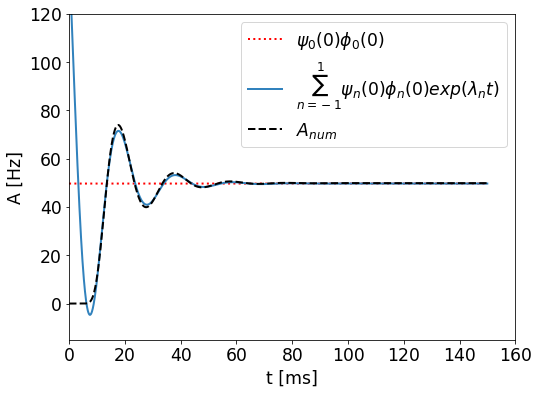

In [28]:
plt.figure(figsize=(8,6))
plt.plot(time,1000*nu[:,1], label='$\psi_0(0)\phi_0(0)$',c='r',ls=':',lw=2)
plt.plot(time,1000*nu[:,3], label='$\sum_{n=-1}^1\psi_n(0)\phi_n(0)exp(\lambda_nt)$',lw=2)
#plt.plot(time,1000*nu[:,5], label='$\sum_{n=-2}^2\psi_n(0)\phi_n(0)exp(\lambda_nt)$',lw=2,c='orange',ls='--')
plt.plot(t_A,1000*A,label='$A_{num}$',ls='--',c='k',lw=2)
plt.xlabel('t [ms]')
plt.ylabel('A [Hz]')
plt.legend()
plt.xlim(0,160)
plt.ylim(-15,120)
plt.savefig('Amodefirst.pdf')

/Users/gallo/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


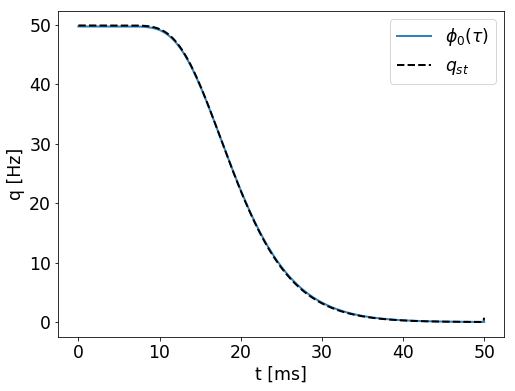

In [29]:
phi=1*vec[:,0]

norm=abs(np.sum(phi.real)*dt)
phi=phi/norm

if phi[0].real<0:
    phi=phi*(-1)


plt.figure(figsize=(8,6))
plt.plot(t_,phi*1000, label='$\phi_0(τ)$',lw=2)
plt.plot(t_q,q[:,-1]*1000,label='$q_{st}$',ls='--',c='k',lw=2)
plt.xlabel('t [ms]')
plt.ylabel('q [Hz]')
plt.legend()
plt.savefig('q_st.pdf')

dt convergence

In [30]:

dt_list=[1,0.5,0.2,0.1,0.05]
eigv_list=[]

t_window=50

for dt in dt_list:
    N=int(t_window/dt)
    L=np.zeros((N+1,N+1))
    
    for i in range(N-1):
        L[0,i+1]=RHO(i*dt,mu,V_th,D)*dt
        L[i+1,i+1]=-1-RHO(i*dt,mu,V_th,D)*dt
        L[i+2,i+1]=1
    
    L[0,0]=-1
    L[1,0]=1
    L[0,N]=1
    L[N,N]=-1
    
    eigv, vec = np.linalg.eig(L)
    eigv=eigv/dt
    arr_idx = np.argsort(eigv.real)

    for i in range(int((len(arr_idx))/2)): 
    
        if eigv[arr_idx[::-1][2*i+1]].imag<0 :
        
            first=1*arr_idx[::-1][2*i+1]
            second=1*arr_idx[::-1][2*i+2]
        
            arr_idx[::-1][2*i+1]=second
            arr_idx[::-1][2*i+2]=first
        
            
    eigv = eigv[arr_idx[::-1]]
    eigv_list.append(eigv)




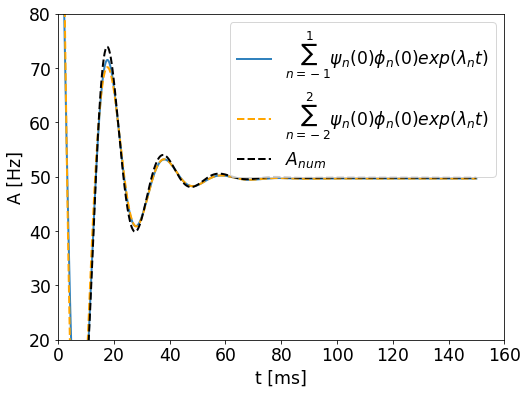

In [31]:
plt.figure(figsize=(8,6))
#plt.plot(time,1000*nu[:,1], label='$\psi_0(0)\phi_0(0)$',c='r',ls=':',lw=2)
plt.plot(time,1000*nu[:,3], label='$\sum_{n=-1}^1\psi_n(0)\phi_n(0)exp(\lambda_nt)$',lw=2)
plt.plot(time,1000*nu[:,5], label='$\sum_{n=-2}^2\psi_n(0)\phi_n(0)exp(\lambda_nt)$',lw=2,c='orange',ls='--')
plt.plot(t_A,1000*A,label='$A_{num}$',ls='--',c='k',lw=2)
plt.xlabel('t [ms]')
plt.ylabel('A [Hz]')
plt.legend()
plt.xlim(0,160)
plt.ylim(20,80)
plt.savefig('Amodefirst2.pdf')


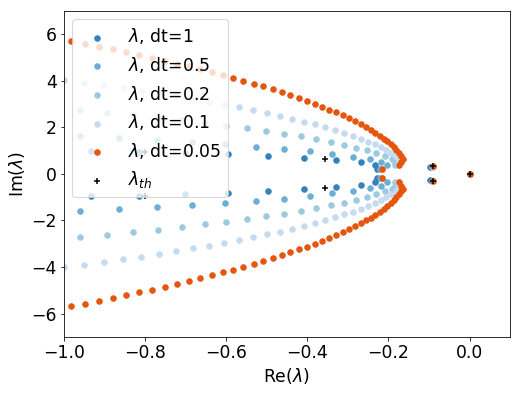

In [32]:
th_spect=th_spectrum(5,mu,V_th,D)

plt.figure(figsize=(8, 6))
for i,eigv in enumerate(eigv_list):
    plt.scatter(eigv.real, eigv.imag, s=30, marker='o',label='$\lambda$, dt='+str(dt_list[i]))
    
for l in th_spect:
    plt.scatter(l.real, l.imag, s=30, marker='+', c='k')
    

plt.scatter(10, 0, s=30, marker='+', c='k',label='$\lambda_{th}$')
    
plt.legend()
plt.xlabel('Re($\lambda$)')
plt.ylabel('Im($\lambda$)')
plt.xlim(-1,0.1)
plt.ylim(-7,7)
plt.savefig('lambda.pdf')

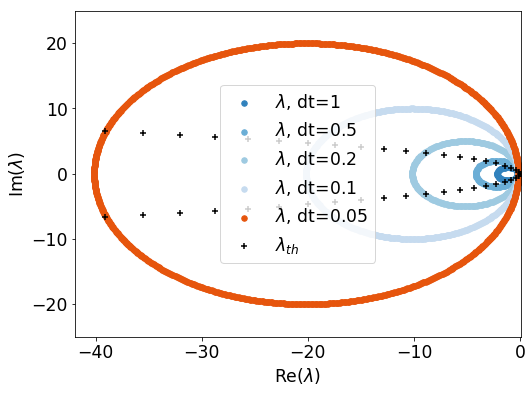

In [33]:
th_spect=th_spectrum(150,mu,V_th,D)

plt.figure(figsize=(8, 6))
for i,eigv in enumerate(eigv_list):
    plt.scatter(eigv.real, eigv.imag, s=30, marker='o',label='$\lambda$, dt='+str(dt_list[i]))
    
for l in th_spect:
    plt.scatter(l.real, l.imag, s=30, marker='+', c='k')
    

plt.scatter(10, 0, s=30, marker='+', c='k',label='$\lambda_{th}$')
    
plt.legend()
plt.xlabel('Re($\lambda$)')
plt.ylabel('Im($\lambda$)')
plt.xlim(-42,0.1)
plt.ylim(-25,25)
plt.savefig('lambda_big.pdf')

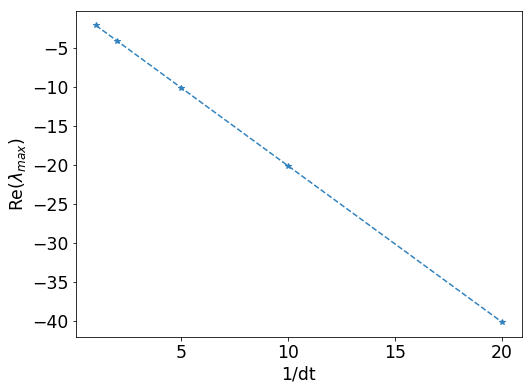

In [34]:
l_inf=[]
for i,eigv in enumerate(eigv_list):
    l_inf.append(eigv[-1].real)
    
    
plt.figure(figsize=(8,6))
plt.plot([1/i for i in dt_list],l_inf,marker='*',ls='--')
plt.xlabel('1/dt')
plt.ylabel('Re($\lambda_{max}$) ')
plt.savefig('Re.pdf')

N_window

In [35]:


window_list=[50,60,70,80,90,100]
eigv_list=[]

dt=0.1

for t_window in window_list:
    N=int(t_window/dt)
    L=np.zeros((N+1,N+1))
    
    for i in range(N-1):
        L[0,i+1]=RHO(i*dt,mu,V_th,D)*dt
        L[i+1,i+1]=-1-RHO(i*dt,mu,V_th,D)*dt
        L[i+2,i+1]=1
    
    L[0,0]=-1
    L[1,0]=1
    L[0,N]=1
    L[N,N]=-1
    
    eigv, vec = np.linalg.eig(L)
    eigv=eigv/dt
    arr_idx = np.argsort(eigv.real)

    for i in range(int((len(arr_idx))/2)): 
    
        if eigv[arr_idx[::-1][2*i+1]].imag<0 :
        
            first=1*arr_idx[::-1][2*i+1]
            second=1*arr_idx[::-1][2*i+2]
        
            arr_idx[::-1][2*i+1]=second
            arr_idx[::-1][2*i+2]=first
        
            
    eigv = eigv[arr_idx[::-1]]
    eigv_list.append(eigv)




(-7, 7)

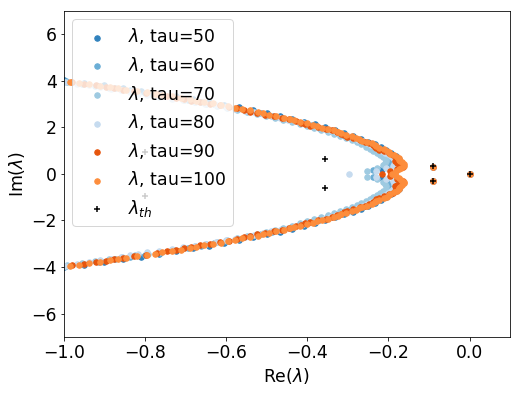

In [36]:


th_spect=th_spectrum(150,mu,V_th,D)

plt.figure(figsize=(8, 6))
for i,eigv in enumerate(eigv_list):
    plt.scatter(eigv.real, eigv.imag, s=30, marker='o',label='$\lambda$, tau='+str(window_list[i]))
    
for l in th_spect:
    plt.scatter(l.real, l.imag, s=30, marker='+', c='k')
    

plt.scatter(10, 0, s=30, marker='+', c='k',label='$\lambda_{th}$')
    
plt.legend()
plt.xlabel('Re($\lambda$)')
plt.ylabel('Im($\lambda$)')
plt.xlim(-1,0.1)
plt.ylim(-7,7)

# Mattia

x' = y
y' = c*(a-x+b*y)



In [30]:
def fun(z, t,a,b,c):
    x, y = z
    return np.array([y, c*(a-x+b*y)])

In [31]:
a=R
b=2*(1/th_spect[1]).real
c=(th_spect[1]*th_spect[2]).real

In [32]:
A0=(qn0[0].real+2*(an0[1]*qn0[1]).real)[0]
Apoint0=(2*(an0[1]*qn0[1]*lambda_list[1]).real)[0]

In [33]:
print(A0,Apoint0)

0.14386141883 -0.026289608626


/Users/gallo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


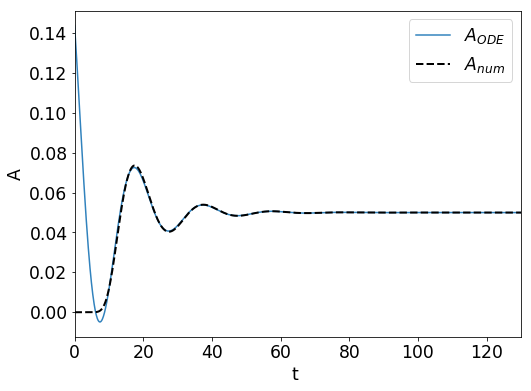

In [34]:
from scipy.integrate import odeint
tmax, dt = 130, 0.1
t = np.linspace(0, tmax, num=np.round(tmax/dt)+1)


sol = odeint(fun, [A0,Apoint0], t, args=(a,b,c))[..., 0]

plt.figure(figsize=(8,6))
plt.plot(t, sol,label='$A_{ODE}$')
#plt.plot(t+7.8, 1000*sol,label='$A_{ODE}$ shifted',c='r')
#plt.plot(t_A,1000*A,label='$A_{num}$',ls='--',c='k',lw=2)
#plt.plot(t_A,a_p,label='$A=\sum_n^{20} P_n(t)$',ls='--',c='k',lw=2)
plt.plot(t_A,a_p,label='$A_{num}$',ls='--',c='k',lw=2)
plt.legend()
plt.xlabel('t ')
plt.ylabel('A')
plt.legend()
plt.xlim(0,130)
plt.savefig('AODE.pdf')

In [51]:
dt=1


def test_(t,l):
    int_=0
    for j in range(int(t/dt-1)):
        x=j*dt
        xn=(j+1)*dt
        
        first=np.exp(-l*x)*P(x,mu,V_th,D)
        second=np.exp(-l*xn)*P(xn,mu,V_th,D)
        int_+=dt*(first+second)*0.5
    return int_

def int_comp(n,Nmax):

    integral=0
    l=th_spect[n]
    for i in range(Nmax):
        t=(i+1)*dt
        integral+=dt - dt*test_(t,l)

    print('integral',1/(integral))
    print('numerique',an0[n]*qn0[n])

In [52]:
int_comp(1,1000)

integral (0.0491515960304+0.0269067995635j)
numerique [ 0.04709704+0.02899478j]


In [53]:
int_comp(2,1000)

integral (0.0491515960304-0.0269067995635j)
numerique [ 0.04709704-0.02899478j]


In [55]:
int_comp(3,1000)

integral (8.01699453786e-36-5.51182481253e-37j)
numerique [ 0.01492102+0.00042962j]


Change initial contion 

In [139]:
t_window=50
dt=0.1
N=int(t_window/dt)

N_sim=int(150/dt)

In [140]:
mu_i=0.05
mu=mu_i
D=0.00225 
V_th=1


q_old=np.zeros((N+1,1))
q_old[0]=1

q=np.zeros((N+1,int(N_sim/10)))

A=np.zeros((N_sim,1))

q_new=np.zeros((N+1,1))

i_store=0

for it in range(N_sim):
    
    t=it*dt
   
    A[it]=q_old[0]#/dt
    q_new = np.zeros((N + 1, 1))
   

    for ir in range(N):
        
        
        rho_ =  RHO(ir*dt,mu,V_th,D)


        q_new[ir + 1] = q_old[ir] * (1 - dt * rho_)
        q_new[0] += dt * rho_ * q_old[ir]

    
    rho = RHO(N*dt,mu,V_th,D)
    q_new[N] += q_old[N] * (1 - dt * rho)
    q_new[0] += dt * rho_ * q_old[N]
    
    q_new/=(np.sum(q_new*dt))


    q_old = q_new

    
    
    if it%10==0:
        q[:,i_store]=q_new.flatten()
        i_store+=1
        
        
q_initial=q[:,-1]

In [141]:
mu=0.05 
D=0.00225 
V_th=1


#q_old=np.zeros((N+1,1))
q_old=q_initial

q=np.zeros((N+1,int(N_sim/10)))

A=np.zeros((N_sim,1))

q_new=np.zeros((N+1,1))

i_store=0

for it in range(N_sim):
    
    t=it*dt
   
    A[it]=q_old[0]#/dt
    q_new = np.zeros((N + 1, 1))
   

    for ir in range(N):
        
        
        rho_ =  RHO(ir*dt,mu,V_th,D)


        q_new[ir + 1] = q_old[ir] * (1 - dt * rho_)
        q_new[0] += dt * rho_ * q_old[ir]

    
    rho = RHO(N*dt,mu,V_th,D)
    q_new[N] += q_old[N] * (1 - dt * rho)
    q_new[0] += dt * rho_ * q_old[N]
    
    q_new/=(np.sum(q_new*dt))


    q_old = q_new

    
    
    if it%10==0:
        q[:,i_store]=q_new.flatten()
        i_store+=1
        

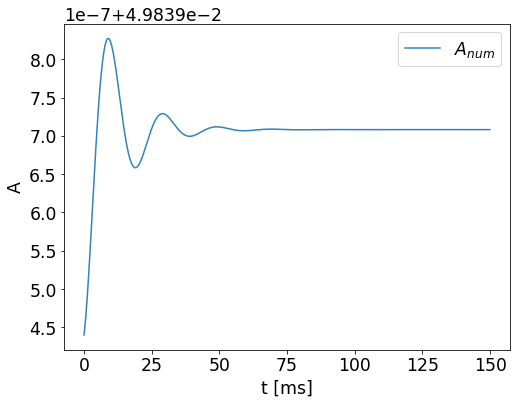

In [142]:
t_A=[(j)*dt for j in range(N_sim)]
plt.figure(figsize=(8,6))
plt.plot(t_A,A,label='$A_{num}$')
plt.xlabel('t [ms]')
plt.ylabel('A')
plt.legend()

In [143]:
th_spect=th_spectrum(3,mu,V_th,D)
a=mu/V_th
b=2*(1/th_spect[1]).real
c=(th_spect[1]*th_spect[2]).real

In [31]:
from scipy.integrate import odeint
tmax, dt = 130, 0.1
t = np.linspace(0, tmax, num=np.round(tmax/dt)+1)


sol = odeint(fun, [mu_i,0], t, args=(a,b,c))[..., 0]

plt.figure(figsize=(8,6))
plt.plot(t, sol,label='$A_{ODE}$')
plt.plot(t_A,a_p,label='$A=\sum_n^20 P_20(t)$',ls='--',c='k',lw=2)
plt.legend()
plt.xlabel('t ')
plt.ylabel('A ')
plt.legend()
plt.xlim(0,130)



/Users/gallo/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


NameError: name 'fun' is not defined

## Kumulant

In [2]:
def fact(n):
    """fact(n): calcule la factorielle de n (entier >= 0)"""
    x=1
    for i in range(2,n+1):
        x*=i
    return x

def k(cv2,r,n):
    
    return fact(int(2*n))/(cv2*(2**n)*fact(n))*(cv2/r)**n




def kumulant(cv2,r,N):
    
    list_k=[2*np.pi*1j]
   
    for i in range(N):
 
        n=i+1
    
        list_k.append((-1)**n*k(cv2,r,n)/fact(n))


    list_k=list(reversed(np.copy(list_k)))
    return list_k


def eigenvalue_app(cv2,r):
    return -2*np.pi**2*cv2*r + 2*np.pi*r*1j

In [3]:
R=1.2
Cv_vec=np.linspace(0.01,0.9,10)

lk2=[]
lk3=[]
lk4=[]
lkinv=[]
gamma_s=[]
gamma_e=[]

for cv in Cv_vec:
  
    lkinv.append(eigenvalue_app(cv**2,R))
    lk2.append(np.roots(kumulant(cv**2,R,2))[-1])
    lk3.append(np.roots(kumulant(cv**2,R,3))[-1])
    lk4.append(np.roots(kumulant(cv**2,R,4))[-1])
    
    gamma_s.append(k(cv**2,R,3)/(k(cv**2,R,2))**(3/2))
    gamma_e.append(k(cv**2,R,4)/(k(cv**2,R,2))**(2))
   

lk2=np.copy(lk2)
lk3=np.copy(lk3)
lk4=np.copy(lk4)
lkinv=np.copy(lkinv)
gamma_s=np.copy(gamma_s)
gamma_e=np.copy(gamma_e)

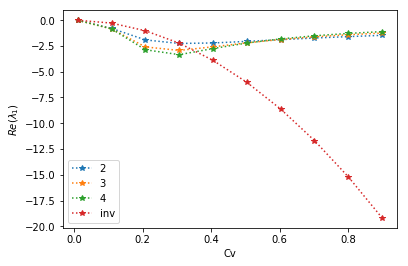

In [4]:
plt.plot(Cv_vec,lk2.real,marker='*',ls=':',label='2')
plt.plot(Cv_vec,lk3.real,marker='*',ls=':',label='3')
plt.plot(Cv_vec,lk4.real,marker='*',ls=':',label='4')
plt.plot(Cv_vec,lkinv.real,marker='*',ls=':',label='inv')



plt.ylabel('$Re(\lambda_1)$')
plt.xlabel('Cv')
plt.legend()

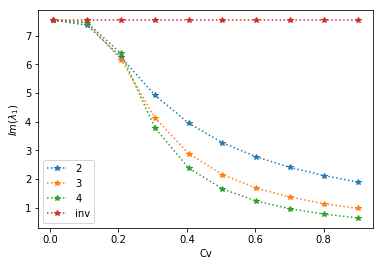

In [5]:
plt.plot(Cv_vec,lk2.imag,marker='*',ls=':',label='2')
plt.plot(Cv_vec,lk3.imag,marker='*',ls=':',label='3')
plt.plot(Cv_vec,lk4.imag,marker='*',ls=':',label='4')
plt.plot(Cv_vec,lkinv.imag,marker='*',ls=':',label='inv')


plt.ylabel('$Im(\lambda_1)$')
plt.xlabel('Cv')
plt.legend()


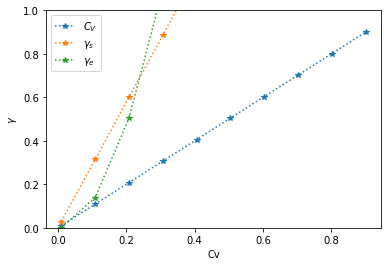

In [6]:
plt.figure()
plt.plot(Cv_vec,Cv_vec,marker='*',ls=':',label='$C_V$')
plt.plot(Cv_vec,gamma_s,marker='*',ls=':',label='$\gamma_s$')
plt.plot(Cv_vec,gamma_e,marker='*',ls=':',label='$\gamma_e$')
plt.ylabel('$\gamma$')
plt.xlabel('Cv')
plt.ylim(0,1)
plt.legend()
plt.show()